## Connectivity history
*by Philipp Schlegel, 2018*

In this notebook, we will try reconstructing a neuron's connectivity history by using the edition timestamps on treenodes postsynaptic of our neuron of interest. Edition timestamps should be a decent proxy as they also reflect the last time a neuron has been merged.

In particular, we want to know how many new neurons were found on a given day.

Requirements:
- pymaid (http://pymaid.readthedocs.io/en/latest/)

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import pymaid

# Use your own credentials here
rm = pymaid.CatmaidInstance('server_url', 'server_user', 'server_pw', 'authtoken')

INFO  : Global CATMAID instance set. (pymaid)


First, we will fetch our neuron of interest. Here we use a VA6 PN. It's one of the very first neurons to be traced (check out the low skeleton ID) - so it is bound to have a long history.

In [95]:
n = pymaid.get_neuron(16)

In [62]:
n

,
type,<class 'pymaid.core.CatmaidNeuron'>
neuron_name,PN glomerulus VA6 017 DB
skeleton_id,16
n_nodes,12743
n_connectors,2031
n_branch_nodes,774
n_end_nodes,823
n_open_ends,280
cable_length,2866.11
review_status,NA


Because we want to exclude fragments and single-node partners, we will first have to compile a list of "partners of interest". We are doing this the lazy way here but you could e.g. also subset by neurons that have a soma.

In [74]:
partners = pymaid.get_partners(n, directions='outgoing', min_size=500)
partner_skids = partners.skeleton_id.values

INFO  : Fetching connectivity table for 1 neurons (pymaid)
INFO  : Done. Found 0 pre-, 191 postsynaptic and 0 gap junction-connected neurons (pymaid)


Next, we will fetch detailed information on its **presynapses**.

In [98]:
cn_details = pymaid.get_connector_details(n.presynapses)
cn_details.head()

INFO  : Data for 1609 of 1609 unique connector IDs retrieved (pymaid)


,connector_id,presynaptic_to,postsynaptic_to,presynaptic_to_node,postsynaptic_to_node
0,97895,16,"[3021737, 11010, 10378]",97891,"[97887, 20901896, 19365715]"
1,97954,16,"[8430509, 8279765, 3021737]",2591,"[27359078, 26835461, 97943]"
2,98300,16,"[8279765, 3021737, 10378]",2665,"[26835218, 98292, 19137144]"
3,98373,16,"[533335, 8279765, 3021737, 10378]",2646,"[27977553, 26835206, 98371, 19258071]"
4,98415,16,"[8279765, 7634, 200094, 30358, 3021737]",2654,"[26835620, 554403, 1588990, 1670669, 98412]"


Next, we need to get the edition timestamps. Please note that we are only going look **downstream** of the VA6 PN. So we will restrict us to timestamps of nodes *postsynaptic* to above connectors.

In [99]:
# Get a list of all treenode IDs -> need to unpack the list
# Note that this would look different for upstream partners as "presynaptic_to_node" is not a list
all_nodes = [n for l in cn_details.postsynaptic_to_node.values for n in l]

# Get details and set the treenode ID as index
tn_details = pymaid.get_node_details(all_nodes).set_index('treenode_id')
tn_details.head()

,creation_time,user,edition_time,editor,reviewers,review_times
treenode_id,,,,,,
97887,2015-04-27 17:50:00,12,2017-03-16 14:01:00,12,[11],[2015-04-28 17:00:00]
97943,2015-04-27 17:51:00,12,2017-03-16 14:01:00,12,[],[]
98292,2015-04-27 17:57:00,12,2017-03-16 14:01:00,12,[11],[2015-04-28 17:01:00]
98332,2015-04-27 17:58:00,12,2017-03-16 14:01:00,12,[],[]
98371,2015-04-27 17:58:00,12,2017-03-16 14:01:00,12,[],[]


We need to be able to map treenode IDs to skeleton IDs. Let's fetch that information as dictionary:

In [97]:
# This function sometimes breaks if too many parallel queries - we will restrict that
rm.max_threads = 10
tn_to_skid = pymaid.get_skid_from_treenode(set(all_nodes))

Now we have all the data we need. Just gotta put it together: for each postsynaptic node, get its skeleton's ID and the edition time.

In [41]:
# Collect raw data
data = [[tn_to_skid[n], n, tn_details.loc[str(n), 'edition_time']] for l in cn_details.postsynaptic_to_node for n in l]

# Turn into pandas DataFrame
connections = pd.DataFrame(data, columns=['skeleton_id', 'treenode_id', 'edition_time'])
connections.head()

,skeleton_id,treenode_id,edition_time
0,3021737,97887,2017-03-16 14:01:00
1,11010,20901896,2017-12-07 16:48:00
2,10378,19365715,2017-11-02 22:49:00
3,8430509,27359078,2018-05-08 20:18:00
4,8279765,26835461,2018-04-26 19:14:00


This table contains also small fragments and single-node partners: we need to intersect it with the "partners of interest" we collected earlier.

In [75]:
connections = connections[connections.skeleton_id.isin(partner_skids)]

The next step is to group above data by neurons and by timestamp (day):

In [76]:
cn_grouped = connections.set_index('edition_time').groupby(['skeleton_id', pd.Grouper(freq='D')]).count()
cn_grouped.head(10)

treenode_id
skeleton_id edition_time             
16          2017-10-24              1
6582        2018-01-22             17
            2018-01-24             16
            2018-01-25              3
6662        2018-01-23             18
            2018-01-24              1
7150        2017-12-09             22
7282        2018-03-12             10
            2018-04-03              2
            2018-04-10             12

This already lets us look at how connectivity to each downstream neuron changed over time. Somewhat surprisingly that appeared to have happened in bouts. My best guess is that this happens when a big fragment is merged into either our VA6 PN or the downstream neuron.

For further analysis we need to pivot the dataframe such that we have *a column per neuron* and *a row per day*. While we're at it, we will also build the cumulative sum of synapses. So the value on the last day should be the current number of synapses from VA6.

In [77]:
cn_pivot = cn_grouped.reset_index().pivot(index='edition_time', columns='skeleton_id', values='treenode_id').fillna(0).cumsum(axis=0)

# Have a look at the last row -> should represent today's connectivity
cn_pivot.tail()

skeleton_id,16,6582,6662,7150,7282,7634,7702,8250,8290,9254,...,8297026,8387679,8390388,8406463,8421369,8430509,8463672,8496988,8894477,8929269
edition_time,,,,,,,,,,,,,,,,,,,,,
2018-05-31,1.0,36.0,19.0,22.0,24.0,21.0,16.0,11.0,13.0,15.0,...,27.0,5.0,8.0,5.0,13.0,3.0,13.0,0.0,0.0,0.0
2018-06-13,1.0,36.0,19.0,22.0,24.0,21.0,16.0,11.0,13.0,15.0,...,27.0,5.0,8.0,5.0,13.0,3.0,13.0,0.0,0.0,0.0
2018-06-21,1.0,36.0,19.0,22.0,24.0,21.0,16.0,11.0,13.0,15.0,...,27.0,5.0,8.0,5.0,13.0,3.0,13.0,5.0,1.0,0.0
2018-06-22,1.0,36.0,19.0,22.0,24.0,21.0,16.0,11.0,13.0,15.0,...,27.0,5.0,8.0,5.0,13.0,3.0,13.0,5.0,5.0,0.0
2018-06-25,1.0,36.0,19.0,22.0,24.0,21.0,16.0,11.0,13.0,15.0,...,27.0,5.0,8.0,5.0,13.0,3.0,13.0,5.0,5.0,2.0


We can already plot this. Each line here is a single neuron's synapses from VA6 ove time.

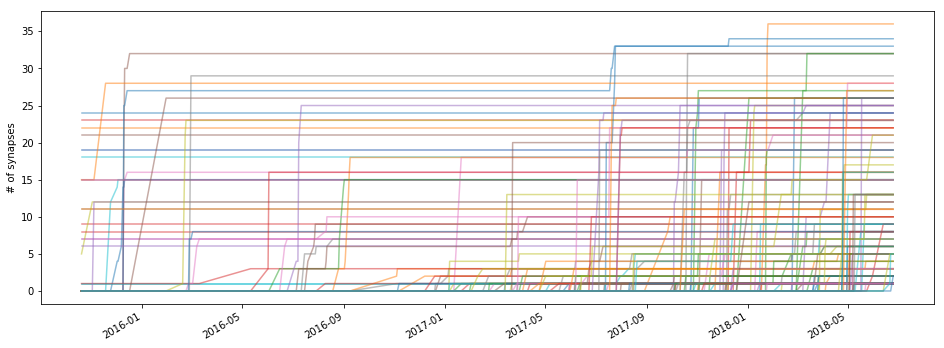

In [101]:
fig, ax = plt.subplots(figsize=(16,6))
_ = cn_pivot.plot.line(legend=False, ax=ax, alpha=.5)

ax.set_ylabel('# of synapses')
ax.set_xlabel('')

plt.show()

Now back to our initial question: "**How many new neurons were discovered on any given day**"?

We will do this in 5 steps:

In [79]:
# 1. Copy the original dataframe
cn_new = cn_pivot.copy()

# 2. Cap synapses at 1
cn_new[cn_new > 1] = 1

# 3. Set first row to 0 (required for next step to make sense)
cn_new.iloc[0, :] = 0

# 4. Get the first derivative -> that way we will see a "1" when the neuron was first encountered
#    and a 0 on any other day
cn_new = cn_new.diff(1)

# 5. Sum newly encountered neurons over each day
cn_new = cn_new.sum(axis=1)

cn_new.head()

edition_time
2015-10-20     0.0
2015-11-02    21.0
2015-11-04     1.0
2015-11-18     0.0
2015-11-24     1.0
dtype: float64

Let's plot this:

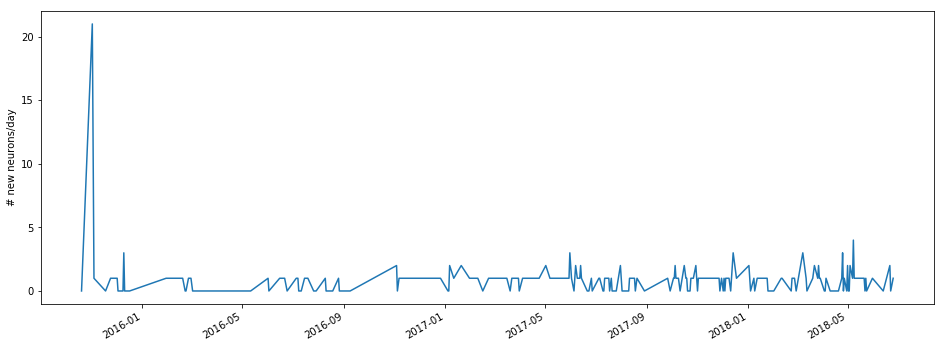

In [104]:
fig, ax = plt.subplots(figsize=(16,6))
_ = cn_new.plot.line(ax=ax)

ax.set_ylabel('# new neurons/day')
ax.set_xlabel('')

plt.show()

And now cumulative:

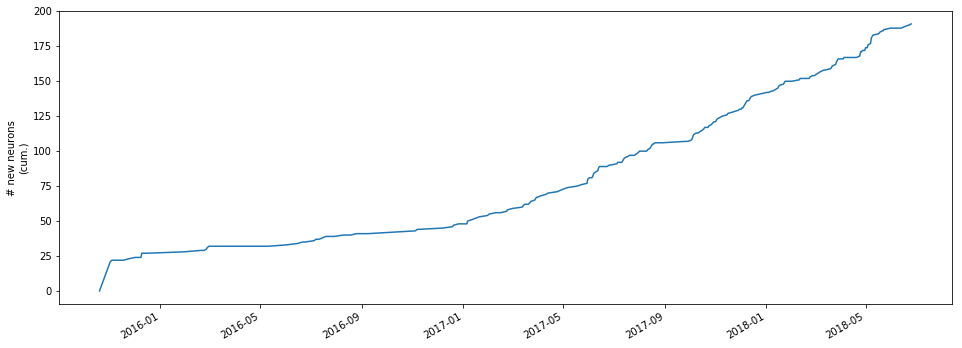

In [103]:
fig, ax = plt.subplots(figsize=(16,6))
_ = cn_new.cumsum().plot.line(ax=ax)

ax.set_ylabel('# new neurons\n(cum.)')
ax.set_xlabel('')

plt.show()

Please note that this neuron has not been actively sampled from. If you e.g. sample randomly from your neuron of interest, you would expect to eventually see the curve flattening.